In [2]:
#logistic example

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline



In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [5]:

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

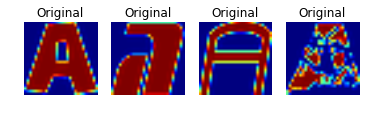

In [14]:
import matplotlib.pyplot as plt

test = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/A.pickle", "rb" ) )

type(test) #numpy.ndarray
test.shape #(1872, 28, 28)
tuple = test[1].shape
tuple

fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

ax1.imshow(test[285])
ax1.set_title('Original')
ax1.axis('off')


ax2.imshow(test[430])
ax2.set_title('Original')
ax2.axis('off')

ax3.imshow(test[300])
ax3.set_title('Original')
ax3.axis('off')

ax4.imshow(test[400])
ax4.set_title('Original')
ax4.axis('off')
plt.show()







In [7]:
#balanced across classes

testA = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/A.pickle", "rb" ) )
testB = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/B.pickle", "rb" ) )
testC = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/C.pickle", "rb" ) )
testD = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/D.pickle", "rb" ) )
testE = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/E.pickle", "rb" ) )
testF = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/F.pickle", "rb" ) )
testG = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/G.pickle", "rb" ) )
testH = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/H.pickle", "rb" ) )
testI = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/I.pickle", "rb" ) )
testJ = pickle.load( open( "/Users/dc/tmp/cs231n/notMNIST_small/J.pickle", "rb" ) )
print (str(testA.shape))
print (str(testB.shape))
print (str(testC.shape))
print (str(testD.shape))
print (str(testE.shape))
print (str(testF.shape))
print (str(testG.shape))
print (str(testH.shape))
print (str(testI.shape))
print (str(testJ.shape))

(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
random_train_dataset, random_train_labels = randomize(train_dataset, train_labels)
random_test_dataset, random_test_labels = randomize(test_dataset, test_labels)
random_valid_dataset, random_valid_labels = randomize(valid_dataset, valid_labels)

In [10]:
print (str(random_train_dataset.shape))
print (str(random_train_labels.shape))
print (str(random_test_dataset.shape))
print (str(random_test_labels.shape))
print (str(random_valid_dataset.shape))
print (str(random_valid_labels.shape))

(200000, 28, 28)
(200000,)
(10000, 28, 28)
(10000,)
(10000, 28, 28)
(10000,)


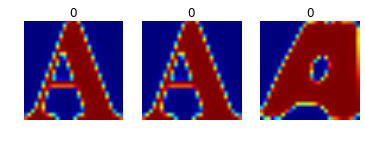

In [15]:
fig1, (i1,i2,i3) = plt.subplots(ncols=3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})

i1.imshow(train_dataset[285])
i1.set_title(train_labels[285])
i1.axis('off')

i2.imshow(test_dataset[430])
i2.set_title(test_labels[430])
i2.axis('off')

i3.imshow(valid_dataset[100])
i3.set_title(valid_labels[100])
i3.axis('off')

plt.show()
#the labels are all wrong!!!!! except for 6.

In [16]:
#measure overlap training/test/validation

ipos=0
for i in train_dataset:
    jpos=0
    for j in test_dataset: 
        if (np.array_equal(i,j) and train_labels[ipos]==test_labels[jpos]) :
            print ("ipos:" , ipos ," jpos:",jpos)
        jpos+=1
    ipos +=1
    

ipos: 285  jpos: 430
ipos: 344  jpos: 144
ipos: 363  jpos: 129
ipos: 381  jpos: 388
ipos: 420  jpos: 360
ipos: 555  jpos: 918
ipos: 1274  jpos: 549
ipos: 1283  jpos: 546
ipos: 1299  jpos: 98
ipos: 1405  jpos: 865
ipos: 1555  jpos: 15


KeyboardInterrupt: 